# Check if we in colab or local machine

In [4]:
if 'google.colab' in str(get_ipython()):
  !pip install split-folders
  print('Running on CoLab')

  from google.colab import drive
  drive.mount('/content/drive')

else:
  print('Not running on CoLab')

RunningInCOLAB = 'google.colab' in str(get_ipython())

Running on CoLab
Mounted at /content/drive


# Import

In [5]:
import os
import pathlib
import tensorflow as tf
import IPython.display as display
from PIL import Image
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import splitfolders
import shutil
import random

# Functions

In [6]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

In [7]:
# Gets the bounding box for only the breast, centered on the y axis
def get_boundary(img):
    idx = 0
    right = 0
    left = 224
    for x in img.numpy():
        for y in x:
            idx += 1
            if y[0] >= 50 and idx > right:
                right = idx        
        idx = 224
        for y in reversed(x):
            idx -= 1
            if y[0] >= 50 and idx < left:
                left = idx
        idx = 0

    # bounding box
    y_min = (img.shape[0]-(right-left))//2
    x_min = left
    y_max = img.shape[0]-y_min
    x_max = right
    # print(right, left)
    return x_min,y_min,x_max,y_max

In [8]:
IMG_WIDTH, IMG_HEIGHT = 224, 224
IMG_AUGMENTED = 10
def generate_images(data_dir, aug_directory, aug_type, aug_func, aug_params, add_plain_dataset=True, exclude_original=False):
    data_dir = pathlib.Path(data_dir)
    sample_shown = False
    # Generates new augmented images
    if aug_type != 'plain':
        for class_name in CLASS_NAMES:
            # List all the images in the given directory (It should be Splitted_Data/Train/plain)
            images_path = list(data_dir.glob(class_name+'/*.png'))
            
            for image in images_path:
                try:
                    # Copy the images in the directory of the augmented img
                    img_name = str(image).split('/')[-1]
                    img = tf.io.read_file(str(image))

                    if add_plain_dataset == True:
                        # Copy image to augmented directory
                        fname = tf.constant(aug_directory+'/'+class_name+'/'+img_name)
                        fwrite = tf.io.write_file(fname, img)

                    # Check if the image is original or not (the image name doesn't start with one of the augmentation type)
                    output = np.prod([(IMG_AUGMENTED if img_name.startswith(aug_type) else 1) for aug_type in augmentation_type])
                    # Check if the augmentation type we did is the same that we want to apply: if an image is vertical flipped, we don't want to apply the vflip to that image, bcs it will produce the original image
                    already_augmented = aug_type in img_name
                    # If I don't want to apply the augmentation to the original
                    if not exclude_original or (exclude_original and output == IMG_AUGMENTED and not already_augmented):
                        img = tf.image.decode_png(img, channels=3)
                        if aug_type == 'crop':
                            x_min,y_min,x_max,y_max = get_boundary(img)
                            im = Image.open(str(image))
                            im = im.crop((x_min,y_min,x_max,y_max))
                            im = im.resize((224,224))
                            im.save(aug_directory+'/'+class_name+'/'+aug_type+'_'+img_name, "PNG")
                            
                            # Show sample
                            if sample_shown == False:
                                sample_shown = True
                                display.display(im)
                        else:
                            aug_img = aug_func(img, *aug_params)
                            enc = tf.image.encode_png(aug_img)
                            fname = tf.constant(aug_directory+'/'+class_name+'/'+aug_type+'_'+img_name)
                            fwrite = tf.io.write_file(fname, enc)

                            # Show sample
                            if sample_shown == False:
                                visualize(img, aug_img)
                                sample_shown = True

                except Exception as error:
                    print(error)
                    continue

# Path

In [9]:
if RunningInCOLAB:
    parent_directory = '/content/drive/MyDrive/Colab Notebooks/'
else:
    parent_directory = '.'

# Create Directories

In [10]:
CLASS_NAMES = ['Density4Benign', 'Density1Benign', 'Density3Malignant', 'Density3Benign', 'Density4Malignant', 'Density2Benign', 'Density1Malignant', 'Density2Malignant']

augmentation_type = ['plain', 'crop', 'vertical_flip', 'horizontal_flip', 'brightness', 'crop_vflip', 'crop_vflip_hflip', 'crop_vflip_hflip_brightness']

test_set_aug_type = ['plain', 'vflip_hflip_brightness']

In [11]:
def create_class_dir(directory, aug_type):
    for class_name in CLASS_NAMES:
        try:
            os.mkdir(os.path.join(parent_directory,directory+'/'+aug_type+'/'+class_name))
            print(class_name," directory created")
        except FileExistsError as error:
            print(error)
            continue

In [12]:
def get_files_from_folder(path):
    files = os.listdir(path)
    return np.asarray(files)

def train_val_split(path_to_data, path_to_train_data, path_to_test_data, train_ratio):
    # get dirs
    _, dirs, _ = next(os.walk(path_to_data))

    # calculates how many train data per class
    data_counter_per_class = np.zeros((len(dirs)))
    for i in range(len(dirs)):
        path = os.path.join(path_to_data, dirs[i])
        files = get_files_from_folder(path)
        data_counter_per_class[i] = len(files)
    test_counter = np.round(data_counter_per_class * (1 - train_ratio))

    # transfers files
    for i in range(len(dirs)):
        path_to_original = os.path.join(path_to_data, dirs[i])
        path_to_save_test = os.path.join(path_to_test_data, dirs[i])
        path_to_save_train = os.path.join(path_to_train_data, dirs[i])

        #creates dir
        if not os.path.exists(path_to_save_test):
            os.makedirs(path_to_save_test)

        if not os.path.exists(path_to_save_train):
            os.makedirs(path_to_save_train)

        files = get_files_from_folder(path_to_original)
        # moves data into test folder
        for j in random.sample(range(0, int(data_counter_per_class[i])), int(test_counter[i])): # take random n (test_counter) unique numbers within the range [0,number_of_img]
        # for j in range(int(test_counter[i])):
            src = os.path.join(path_to_original, files[j])
            dst = os.path.join(path_to_save_test, files[j])
            shutil.copy(src, dst)
        
        # moves data into train folder
        for j in random.sample(range(0, int(data_counter_per_class[i])), int(data_counter_per_class[i]) - int(test_counter[i])):
        # for j in range(int(data_counter_per_class[i]) - int(test_counter[i])):
            src = os.path.join(path_to_original, files[j])
            dst = os.path.join(path_to_save_train, files[j])
            shutil.copy(src, dst)

In [14]:
try:
    # Create Splitted Dataset directory
    path = os.path.join(parent_directory, 'Splitted_Dataset/')
    os.mkdir(path)
    print("Splitted_Dataset directory created")
except FileExistsError as error:
    print(error)
    
try:
    path = os.path.join(parent_directory, 'Splitted_Dataset/Train/')
    os.mkdir(path)
except FileExistsError as error:
    print(error)

try:
    path = os.path.join(parent_directory, 'Splitted_Dataset/Test/')
    os.mkdir(path)
except FileExistsError as error:
    print(error)

# Create Test subdirectories
for test_aug_type in test_set_aug_type:
    try:
        os.mkdir(os.path.join(parent_directory,'Splitted_Dataset/Test/'+test_aug_type))
        print(test_aug_type,"Test directory created")
        create_class_dir('Splitted_Dataset/Test/', test_aug_type)
    except FileExistsError as error:
        print(error)
        create_class_dir('Splitted_Dataset/Test/', test_aug_type)
        continue

# Create subdirectories
for aug_type in augmentation_type:
    try:
        os.mkdir(os.path.join(parent_directory,'Splitted_Dataset/Train/'+aug_type))
        print(aug_type," directory created")
        create_class_dir('Splitted_Dataset/Train/', aug_type)
    except FileExistsError as error:
        print(error)
        create_class_dir('Splitted_Dataset/Train/', aug_type)
        continue


[Errno 17] File exists: '/content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/'
[Errno 17] File exists: '/content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Train/'
[Errno 17] File exists: '/content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Test/'
[Errno 17] File exists: '/content/drive/MyDrive/Colab Notebooks/Splitted_Dataset/Test/plain'
Density4Benign  directory created
Density1Benign  directory created
Density3Malignant  directory created
Density3Benign  directory created
Density4Malignant  directory created
Density2Benign  directory created
Density1Malignant  directory created
Density2Malignant  directory created
vflip_hflip_brightness Test directory created
Density4Benign  directory created
Density1Benign  directory created
Density3Malignant  directory created
Density3Benign  directory created
Density4Malignant  directory created
Density2Benign  directory created
Density1Malignant  directory created
Density2Malignant  directory created
[Errno 17] File exists: '/content

In [18]:
original_data_dir = parent_directory+'/Dataset'
train_dir = parent_directory+'/Splitted_Dataset/Train1/'
plain_train_dir = parent_directory+'/Splitted_Dataset/Train1/plain/'
test_dir = parent_directory+'/Splitted_Dataset/Test/'
plain_test_dir = parent_directory+'/Splitted_Dataset/Test/plain'
data_dir = plain_train_dir

# Split the DataSet in 80% train 20% test

In [17]:
train_val_split(original_data_dir, plain_train_dir, plain_test_dir, 0.8)

In [ ]:
# input_folder = "./Dataset"
# output = "./Splitted_Dataset" #where you want the split datasets saved. one will be created if none is set

# splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .2)) # ratio of split are in order of train/val/test. You can change to whatever you want. For train/val sets only, you could do .75, .25 for example.

# Augment Train Set

## Generate and save vertical flip images

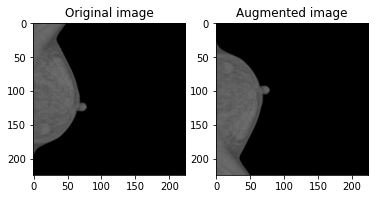

In [ ]:
vflip_train_dir =  train_dir+'vertical_flip/'
generate_images(data_dir, vflip_train_dir, 'vertical_flip', tf.image.flip_up_down, [])

## Generate and save horizontal flip images

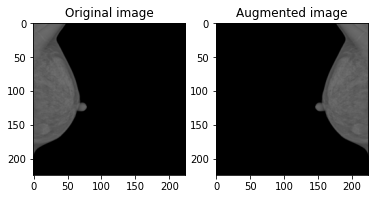

In [ ]:
hflip_train_dir =  train_dir+'horizontal_flip/'
generate_images(data_dir, hflip_train_dir, 'horizontal_flip', tf.image.flip_left_right, [])

## Brightness

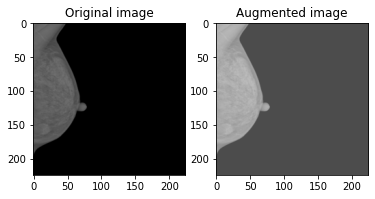

In [ ]:
brightness_train_dir =  train_dir+'brightness/'
generate_images(data_dir, brightness_train_dir, 'brightness', tf.image.adjust_brightness, [+0.3])

## Breast centered crop

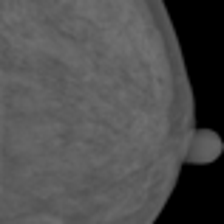

In [ ]:
crop_train_dir =  train_dir+'crop/'
generate_images(data_dir, crop_train_dir, 'crop', tf.image.crop_to_bounding_box, [])

## Cropped and vertical flipped

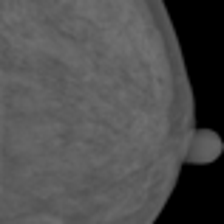

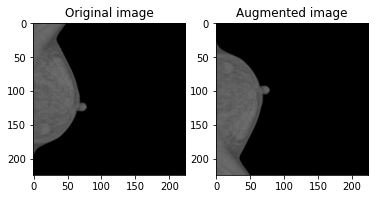

In [ ]:
cropvflip_train_dir =  train_dir+'crop_vflip/'
generate_images(data_dir, cropvflip_train_dir, 'crop', tf.image.crop_to_bounding_box, [])
generate_images(cropvflip_train_dir, cropvflip_train_dir, 'vertical_flip', tf.image.flip_up_down, [], add_plain_dataset=False)

## Crop, vflip, hflip

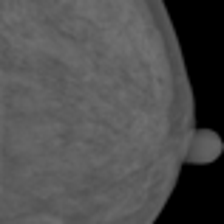

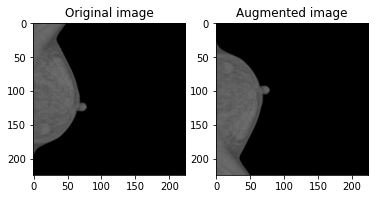

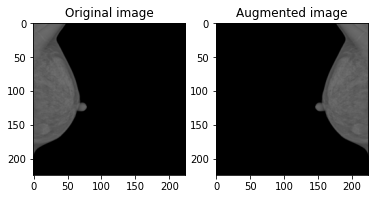

In [ ]:
crop_vflip_hflip_train_dir =  train_dir+'crop_vflip_hflip/'
generate_images(data_dir, crop_vflip_hflip_train_dir, 'crop', tf.image.crop_to_bounding_box, [])
generate_images(crop_vflip_hflip_train_dir, crop_vflip_hflip_train_dir, 'vertical_flip', tf.image.flip_up_down, [], add_plain_dataset=False)
generate_images(crop_vflip_hflip_train_dir, crop_vflip_hflip_train_dir, 'horizontal_flip', tf.image.flip_left_right, [], add_plain_dataset=False)

## Crop, vflip, hflip, brightness

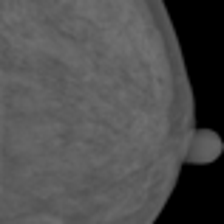

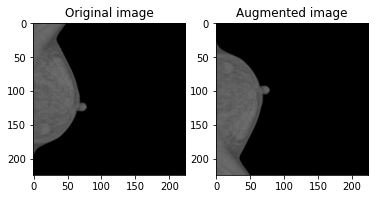

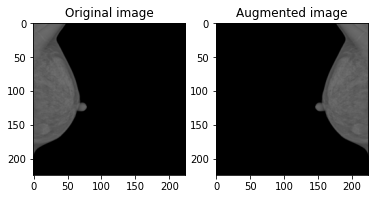

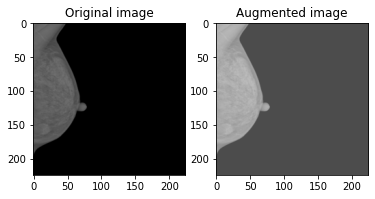

In [ ]:
crop_vflip_hflip_brightness_train_dir =  train_dir+'crop_vflip_hflip_brightness/'
generate_images(data_dir, crop_vflip_hflip_brightness_train_dir, 'crop', tf.image.crop_to_bounding_box, [])
generate_images(crop_vflip_hflip_brightness_train_dir, crop_vflip_hflip_brightness_train_dir, 'vertical_flip', tf.image.flip_up_down, [], add_plain_dataset=False)
generate_images(crop_vflip_hflip_brightness_train_dir, crop_vflip_hflip_brightness_train_dir, 'horizontal_flip', tf.image.flip_left_right, [], add_plain_dataset=False)
generate_images(crop_vflip_hflip_brightness_train_dir, crop_vflip_hflip_brightness_train_dir, 'brightness', tf.image.adjust_brightness, [+0.3], add_plain_dataset=False)

# Augment Test Set

## Vflip, hflip, brightness

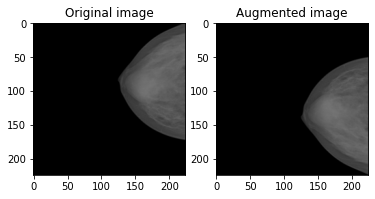

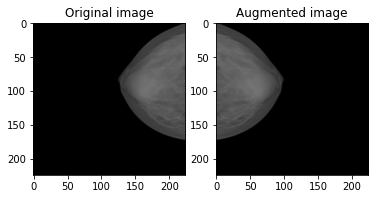

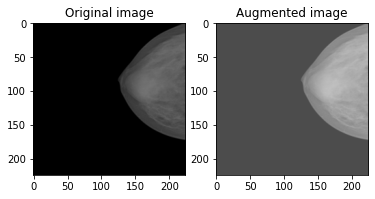

In [21]:
vflip_hflip_brightness_test_dir =  test_dir+'vflip_hflip_brightness/'
generate_images(plain_test_dir, vflip_hflip_brightness_test_dir, 'vertical_flip', tf.image.flip_up_down, [])
generate_images(vflip_hflip_brightness_test_dir, vflip_hflip_brightness_test_dir, 'horizontal_flip', tf.image.flip_left_right, [], add_plain_dataset=False)
generate_images(vflip_hflip_brightness_test_dir, vflip_hflip_brightness_test_dir, 'brightness', tf.image.adjust_brightness, [+0.3], add_plain_dataset=False)